In [1]:
%matplotlib inline


# Measure region properties

This example shows how to measure properties of labelled image regions. We
first analyze an image with two ellipses. Below we show how to explore
interactively the properties of labelled objects.


In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate


image = np.zeros((600, 600))

rr, cc = ellipse(300, 350, 100, 220)
image[rr, cc] = 1

image = rotate(image, angle=15, order=0)

rr, cc = ellipse(100, 100, 60, 50)
image[rr, cc] = 1

label_img = label(image)
regions = regionprops(label_img)

We use the :py:func:`skimage.measure.regionprops` result to draw certain
properties on each region. For example, in red, we plot the major and minor
axes of each ellipse.



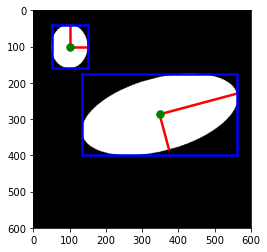

In [3]:
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis((0, 600, 600, 0))
plt.show()

We use the :py:func:`skimage.measure.regionprops_table` function to compute
(selected) properties for each region. Note that
``skimage.measure.regionprops_table`` actually computes the properties,
whereas ``skimage.measure.regionprops`` computes them when they come in use
(lazy evaluation).



In [4]:
props = regionprops_table(label_img, properties=('centroid',
                                                 'orientation',
                                                 'axis_major_length',
                                                 'axis_minor_length'))

We now display a table of these selected properties (one region per row),
the ``skimage.measure.regionprops_table`` result being a pandas-compatible
dict.



In [5]:
pd.DataFrame(props)

,centroid-0,centroid-1,orientation,axis_major_length,axis_minor_length
0,100.000000,100.000000,0.000000,119.807049,99.823995
1,286.914167,348.412995,-1.308966,440.015503,199.918850


It is also possible to explore interactively the properties of labelled
objects by visualizing them in the hover information of the labels.
This example uses plotly in order to display properties when
hovering over the objects.



In [6]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
from skimage import data, filters, measure, morphology

img = data.coins()
# Binary image, post-process the binary mask and compute labels
threshold = filters.threshold_otsu(img)
mask = img > threshold
mask = morphology.remove_small_objects(mask, 50)
mask = morphology.remove_small_holes(mask, 50)
labels = measure.label(mask)

fig = px.imshow(img, binary_string=True)
fig.update_traces(hoverinfo='skip') # hover is only for label info

props = measure.regionprops(labels, img)
properties = ['area', 'eccentricity', 'perimeter', 'intensity_mean']

# For each label, add a filled scatter trace for its contour,
# and display the properties of the label in the hover of this trace.
for index in range(1, labels.max()):
    label_i = props[index].label
    contour = measure.find_contours(labels == label_i, 0.5)[0]
    y, x = contour.T
    hoverinfo = ''
    for prop_name in properties:
        hoverinfo += f'<b>{prop_name}: {getattr(props[index], prop_name):.2f}</b><br>'
    fig.add_trace(go.Scatter(
        x=x, y=y, name=label_i,
        mode='lines', fill='toself', showlegend=False,
        hovertemplate=hoverinfo, hoveron='points+fills'))

plotly.io.show(fig)